In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import comb

<b>Задание 1.</b>
Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

In [3]:
df1 = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Lj5WClBbCt3fyw")

In [5]:
df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [6]:
df2 = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Vnlvg9uOrMVKhw")

In [7]:
df2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [14]:
A = (df1.query("group == 'A'")).events
B = (df1.query("group == 'B'")).events
C = (df1.query("group == 'C'")).events
ss.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

<b>Задание 2.</b> Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [21]:
pg.homoscedasticity(data = df1, dv = "events", group = "group")

,W,pval,equal_var
levene,2.26226,0.104133,True


<b>Задание 3.</b> Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр <b>random_state=17</b> в методе <b>sample</b>.

In [30]:
As = A.sample(n = 1000, random_state = 17)
Bs = B.sample(n = 1000, random_state = 17)
Cs = C.sample(n = 1000, random_state = 17)

In [31]:
print(ss.shapiro(As))
print(ss.shapiro(Bs))
print(ss.shapiro(Cs))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)
ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)
ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)


<b>Задание 4.</b> Самое время провести тест! 

In [32]:
ss.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

<b>Задание 5.</b> Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

In [33]:
pg.pairwise_tukey(data = df1, dv = "events", between = "group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


<b>Задание 6.</b> Так какие картинки в итоге будем использовать?

In [37]:
max(A.mean(), B.mean(), C.mean())

37.6136

<b>Задание 7.</b> Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента. Какой метод скорее всего пригодится в данном случае?

In [38]:
df2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


<b>Задание 8.</b> Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп.

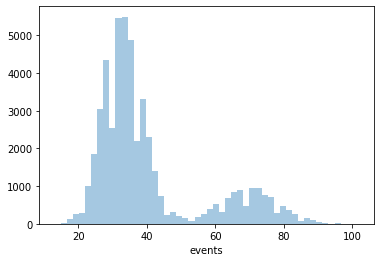

In [43]:
sns.distplot((df2.query("group == 'test'")).events, kde = False);

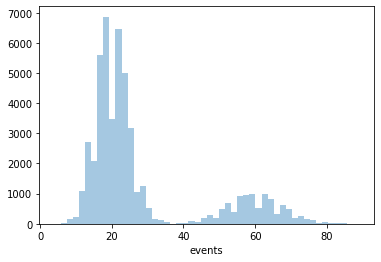

In [44]:
sns.distplot((df2.query("group == 'control'")).events, kde = False);

<b>Задание 9.</b> Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [50]:
df2.groupby(["group", "segment"], as_index = False) \
   .agg({"events" : "mean"})

,group,segment,events
0,control,high,59.970800
1,control,low,20.031575
2,test,high,69.938500
3,test,low,33.025925


In [51]:
df2.groupby(["group", "segment"], as_index = False) \
   .agg({"events" : "median"})

,group,segment,events
0,control,high,60.0
1,control,low,20.0
2,test,high,70.0
3,test,low,33.0


In [52]:
df2.groupby(["group", "segment"], as_index = False) \
   .agg({"events" : "std"})

,group,segment,events
0,control,high,7.805347
1,control,low,4.473576
2,test,high,8.403974
3,test,low,5.720845


<b>Задание 11.</b> Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

In [56]:
model_main = smf.ols("events ~ segment + group + segment:group", data = df2).fit()
anova_lm(model_main)

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


<b>Задание 12.</b> Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

In [59]:
df2["combination"] = df2.group + ' / ' + df2.segment
df2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high


In [61]:
MultiComparison(df2.events, df2.combination).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control / high,control / low,-39.9392,0.001,-40.1073,-39.7711,True
control / high,test / high,9.9677,0.001,9.7551,10.1803,True
control / high,test / low,-26.9449,0.001,-27.113,-26.7768,True
control / low,test / high,49.9069,0.001,49.7388,50.075,True
control / low,test / low,12.9944,0.001,12.888,13.1007,True
test / high,test / low,-36.9126,0.001,-37.0807,-36.7445,True


<b>Задание 13.</b> Визуализируйте результаты теста.

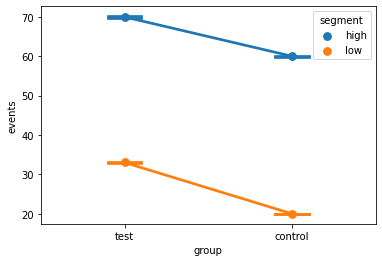

In [62]:
sns.pointplot(x = "group", y = "events", hue = "segment", data = df2, capsize = 0.2);